<a href="https://colab.research.google.com/github/coldsober-irene/drafting/blob/main/RLAgent_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from typing import List, Tuple
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The following class defines the grid world environment. The grid world looks like:

```
____________________________________________________________
|___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
|_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
|_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
|_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
|_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
```



In [22]:
AGENT = 'A'
BOX = 'B'
GOAL = 'G'
DANGER = 'x'
GRID = '_'


class CliffBoxGridWorld:
    """
    Cliff Box Pushing Grid World.
    """
    action_space = [1, 2, 3, 4]
    forces = {
        1: np.array([-1, 0]),
        2: np.array([1,  0]),
        3: np.array([0, -1]),
        4: np.array([0,  1]),
    }
    world_width = 14
    world_height = 6
    goal_pos = np.array([4, 13])
    init_agent_pos = np.array([5, 0])
    init_box_pos = np.array([4, 1])
    danger_region = [
        [(2, 3), (5, 3)],
        [(0, 6), (3, 6)],
        [(0, 7), (2, 7)],
        [(3, 11), (5, 11)],
        [(2, 12), (5, 12)],
    ]

    def __init__(self,
                 episode_length=100,
                 render=False,
                 ):
        """
        The grid world looks like:
        ____________________________________________________________
        |___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
        |_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
        |_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
        |_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
        |_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
        """
        # Environment configurations.
        self.episode_length = episode_length
        self.render = render
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        # Visualization.
        if self.render:
            self.world = np.chararray((self.world_height, self.world_width))
            self.last_agent_pos = copy.deepcopy(self.agent_pos)
            self.last_box_pos = copy.deepcopy(self.box_pos)
            self.world[:] = GRID
            for region in self.danger_region:
                A, B = region
                assert A[1] == B[1], "A[1] != B[1]"
                self.world[A[0]:B[0]+1, A[1]] = DANGER
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
            self.world[self.box_pos[0], self.box_pos[1]] = BOX
            self.world[self.goal_pos[0], self.goal_pos[1]] = GOAL

    def reset(self):
        """
        Resets the environment.

        Returns:
            The initial state (agent position and box position).
        """
        self.timesteps = 0
        self.action_history = []
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        return tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

    def step(self, actions: int):
        """
        Args: actions (a list of int).

        Returns:
            The next state, reward, done, info.
        """
        self.action_history.append(actions)

        # Update the state.
        force = self.forces[actions]
        # check if the agent is near the box
        if np.sum(np.abs(self.agent_pos - self.box_pos)) == 1:
            # check if box is moved
            if all(self.agent_pos + force == self.box_pos):
                # check out of boundary
                self.box_pos = self._check_pos_boundary(pos=self.box_pos + force, box_hard_boundary=True)
        # move the agent
        new_agent_pos = self._check_pos_boundary(self.agent_pos + force)
        if not all(new_agent_pos == self.box_pos):
            self.agent_pos = new_agent_pos
        state = tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

        # Calculate the rewards
        done = self.timesteps == self.episode_length - 1
        # the distance between agents and box
        dist = np.sum(np.abs(self.agent_pos - self.box_pos))
        reward = -1  # -1 for each step
        reward -= dist
        # if agents or box is off the cliff
        if self._check_off_cliff(self.agent_pos) or self._check_off_cliff(self.box_pos):
            reward += -1000
            done = True

        if all(self.box_pos == self.goal_pos):
            reward += 1000
            done = True

        reward -= np.sum(np.abs(self.box_pos - self.goal_pos))

        if self.render:
            self._update_render()

        self.timesteps += 1
        info = {}

        return state, reward, done, info

    def print_world(self):
        """
        Render the world in the command line.
        """
        if len(self.action_history) > 0:
            print(f'Action: {self.action_history[-1]}')
        print(self.world)

    def _check_pos_boundary(self, pos, box_hard_boundary: bool = False):
        """
        Move the given position within the world bound.
        """
        if pos[0] < 0:
            pos[0] = 0
        if pos[0] >= self.world_height:
            pos[0] = self.world_height - 1
        if pos[1] < 0:
            pos[1] = 0
        if pos[1] >= self.world_width:
            pos[1] = self.world_width - 1

        if box_hard_boundary:
            if pos[0] == 0:
                pos[0] += 1
            elif pos[0] == self.world_height - 1:
                pos[0] = self.world_height - 2
            if pos[1] == 0:
                pos[1] += 1

        return pos

    def _check_off_cliff(self, pos):
        """
        Check if the given position is off cliff.
        """
        for region in self.danger_region:
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            if A[0] <= pos[0] <= B[0] and pos[1] == A[1]:
                return True
        return False

    def _update_render(self):
        """
        Update the render information.
        """
        if not all(self.last_agent_pos == self.agent_pos):
                pos = self.last_agent_pos
                if (pos[0] != self.goal_pos[0]) or (pos[1] != self.goal_pos[1]):
                    self.world[pos[0], pos[1]] = GRID

        if not all(self.last_box_pos == self.box_pos):
            pos = self.last_box_pos
            if self.world[pos[0], pos[1]].decode('UTF-8') not in {AGENT}:
                self.world[pos[0], pos[1]] = GRID

        if (self.agent_pos[0] != self.goal_pos[0]) or (self.agent_pos[1] != self.goal_pos[1]):
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
        self.world[self.box_pos[0], self.box_pos[1]] = BOX
        self.last_box_pos = copy.deepcopy(self.box_pos)
        self.last_agent_pos = copy.deepcopy(self.agent_pos)

You need to complete the learn() method of the following class to implement your RL algorithm.


In [23]:
class RLAgent:
    def __init__(self, env, num_episodes, epsilon=0.1, alpha=0.1, gamma=0.99):
        self.action_space = env.action_space
        # Loop through all possible grid spaces, create sub-dictionary for each
        self.q_table = {(agent_x, agent_y, box_x, box_y) : {k: 0 for k in self.action_space}
                        for agent_x in range(env.world_height)
                        for agent_y in range(env.world_width)
                        for box_x in range(env.world_height)
                        for box_y in range(env.world_width)
                        }

        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def act(self, state):
        """Returns the (epsilon-greedy) optimal action from Q-Value table."""
        if np.random.uniform(0,1) < self.epsilon:
            action = self.action_space[np.random.randint(0, len(self.action_space))]
        else:
            q_values_of_state = self.q_table[state]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])

        return action

    def learn(self):
        """Updates Q-values iteratively."""
        rewards = []

        def savedQvalue(state, action):
          return self.q_table.setdefault(state, {}).setdefault(action, 0)

        for _ in range(self.num_episodes):
            cumulative_reward = 0 # Initialise values of each game
            state = self.env.reset()
            done = False

            while not done:
              action = self.act(state)
              next_state, reward, done, _ = self.env.step(action)
              saved_Q_value = savedQvalue(state, action)
              TargetQvalue = max([savedQvalue(next_state, done_action) for done_action in self.action_space])

              # UPDATE Q_VALUES
              self.q_table[state][action] = saved_Q_value + self.alpha * (reward + self.gamma * TargetQvalue - saved_Q_value)

              # UPDATE CUMULATIVE REWARDS
              cumulative_reward += reward

            rewards.append(cumulative_reward)

        return rewards

Here is the game interface where you can manually move the agent.

In [24]:
env = CliffBoxGridWorld(render=True)
env.reset()
env.print_world()
done = False
rewards = []

while not done:
  try:
    action = int(input("Please input the actions \nup: 1, \ndown: 2, \nleft: 3, \nright: 4 \nExit Game: 0 \n: "))
    if not action:
      break
    state, reward, done, info = env.step(action)
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()
  except Exception:
    print()
    print('Invalid action', '\n', '_'*100)

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')

[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'A' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]
Please input the actions 
up: 1, 
down: 2, 
left: 3, 
right: 4 
Exit Game: 0 
: 4
step: 1, state: (5, 1, 4, 1), actions: 4, reward: -14
Action: 4
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'_' b'A' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_

In [25]:
env = CliffBoxGridWorld()
agent = RLAgent(env, num_episodes=1000)
rewards = agent.learn()

In [26]:
print("AGENT Q-TABLE: ", agent.q_table)

AGENT Q-TABLE:  {(0, 0, 0, 0): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 0, 1): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 0, 2): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 0, 3): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 0, 4): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 0, 5): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 0, 6): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 0, 7): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 0, 8): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 0, 9): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 0, 10): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 0, 11): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 0, 12): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 0, 13): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 1, 0): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 1, 1): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 1, 2): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 1, 3): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 1, 4): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 1, 5): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 1, 6): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 1, 7): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 1, 8): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 1, 9): {1: 0, 2: 0, 3: 0, 4: 0}, (0, 0, 1, 10): {1: 

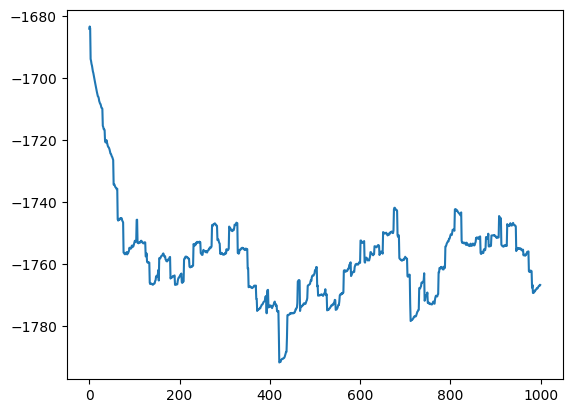

In [27]:
# Smooth plot
weight=0.99
last = rewards[0]
smoothed = []
for v in rewards:
    smoothed_val = last * weight + (1 - weight) * v
    smoothed.append(smoothed_val)
    last = smoothed_val

# Plot the learning curve
plt.plot(smoothed)

You need to complete the following method to visualize your training results.

In [28]:
def visualize(q_table):

    # TODO: Visualize learned V-table and policy.
    for k, v in q_table.items():
      print(k, v)
    #     v_table[key[0]].append(np.mean(list(value.values())))
    #     policy[key[0]].append(actions[np.argmax([value[i] for i in range(1, 5)])])



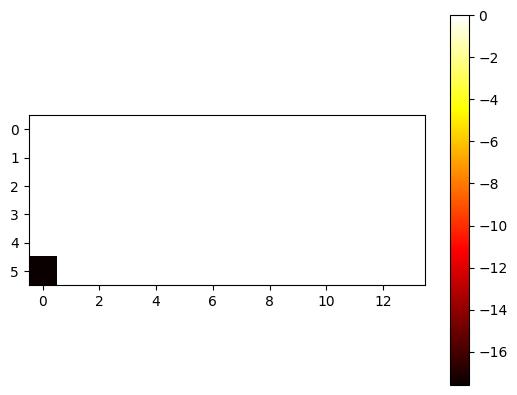

In [29]:
def visualize(q_table):
    # Extract v-values from the Q-table
    v_values = np.zeros((env.world_height, env.world_width))

    for state, actions in q_table.items():
        # Convert state back to positions
        agent_pos = (state[0], state[1])
        box_pos = (state[2], state[3])

        # Get the maximum Q-value for the state
        max_q_value = max(actions.values())

        # Add the maximum Q-value to the agent's position on the grid
        v_values[agent_pos[0], agent_pos[1]] += max_q_value

    # Visualize using matplotlib
    plt.imshow(v_values, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()

visualize(agent.q_table)

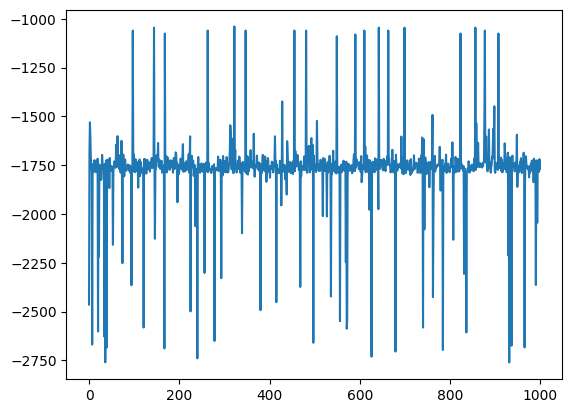

In [34]:
env = CliffBoxGridWorld()
# agent = RandomAgent(env, num_episodes=1000)
# After running the RL agent for V-TABLE AND POLICY:
agent = RLAgent(env, num_episodes=1000)
# rewards = agent.learn()
rewards = agent.learn()
# print(rewards)
# print(len(rewards))
# plt.plot(range(len(rewards)), rewards)
# plt.xlabel('Episode')
# plt.ylabel('Total Reward')
# plt.title('Learning Progress: Episode Rewards vs. Episodes')
# plt.grid(True)
# plt.show()
plt.plot(rewards)